In [11]:
import os
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
# from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import minimize
from pprint import pprint
from tqdm import tqdm

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

Number of available GPUs:  2


In [2]:
def get_image_data(f):
    """
    Returns a tuple (Lens ID, image)
    """
    fits_data = fits.getdata(f, ext=1)
    return fits_data[0][0], fits_data[0][1]


def process_image(image):
    # normalize the image to the range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # apply gamma correction
    gamma = find_gamma(image, desired_median=0.2)
    return np.power(image, gamma)


def objective_function(gamma, image, desired_median):
    gamma_corrected_image = np.power(image, gamma)
    median_value = np.median(gamma_corrected_image)
    return (median_value - desired_median)**2


def find_gamma(image, desired_median=0.2, initial_gamma=0.7):
    result = minimize(objective_function, initial_gamma, args=(image, desired_median), method='Nelder-Mead')
    return result.x[0]

Load the saved model

In [3]:
model = keras.models.load_model('/data/bwedig/lsst-strong-lens-data-challenge/bryce_model.keras')

I0000 00:00:1759698993.877578 2481966 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19504 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:31:00.0, compute capability: 8.9
I0000 00:00:1759698993.879100 2481966 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46551 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:b1:00.0, compute capability: 8.9


Take a quick look as the format that the submission CSV needs to have

In [4]:
example_csv = '/grad/bwedig/lsst-strong-lens-data-challenge/submission_format.csv'
example_df = pd.read_csv(example_csv)
print(example_df.head())

            id  preds   ra  dec  zlens  mag_lens_g  mag_lens_r  mag_lens_i  \
0  7.53391E+16      1 -999 -999   -999        -999        -999        -999   
1  7.46439E+16      0 -999 -999   -999        -999        -999        -999   
2  4.42233E+16      1 -999 -999   -999        -999        -999        -999   
3  6.95818E+16      0 -999 -999   -999        -999        -999        -999   
4  6.95997E+16      1 -999 -999   -999        -999        -999        -999   

   mag_lens_z  mag_lens_y  ...  n_l_sers  vel_disp   RA  Dec  mag_object_g  \
0        -999        -999  ...      -999      -999 -999 -999          -999   
1        -999        -999  ...      -999      -999 -999 -999          -999   
2        -999        -999  ...      -999      -999 -999 -999          -999   
3        -999        -999  ...      -999      -999 -999 -999          -999   
4        -999        -999  ...      -999      -999 -999 -999          -999   

   mag_object_r  mag_object_i  mag_object_z  mag_object_y  z_c

Create an empty version of this

In [5]:
df = example_df.iloc[0:0].copy()
print(df)

Empty DataFrame
Columns: [id, preds, ra, dec, zlens, mag_lens_g, mag_lens_r, mag_lens_i, mag_lens_z, mag_lens_y, ell_l, ell_l_PA, Rein, vel disp, sh, sh_PA, srcx, srcy, mag_src_g, mag_src_r, mag_src_i, mag_src_z, mag_src_y, zsrc, ell_s, ell_s_PA, Reff_s, n_s_sers, ell_m, ell_m_PA, Reff_l, n_l_sers, vel_disp, RA, Dec, mag_object_g, mag_object_r, mag_object_i, mag_object_z, mag_object_y, z_central]
Index: []

[0 rows x 41 columns]


Load the `.fits` files, making sure to stack them correctly

In [ ]:
data_dir = '/data/bwedig/lsst-strong-lens-data-challenge/test_dataset'

fits_files = sorted(glob(os.path.join(data_dir, '*.fits')))
print(f"Found {len(fits_files)} FITS files.")

unique_ids = set([os.path.basename(f).split('.')[0][:-2] for f in fits_files])
print(f"Found {len(unique_ids)} unique IDs.")

Found 500000 FITS files.
Found 100000 unique IDs.


  0%|          | 0/100000 [00:00<?, ?it/s]

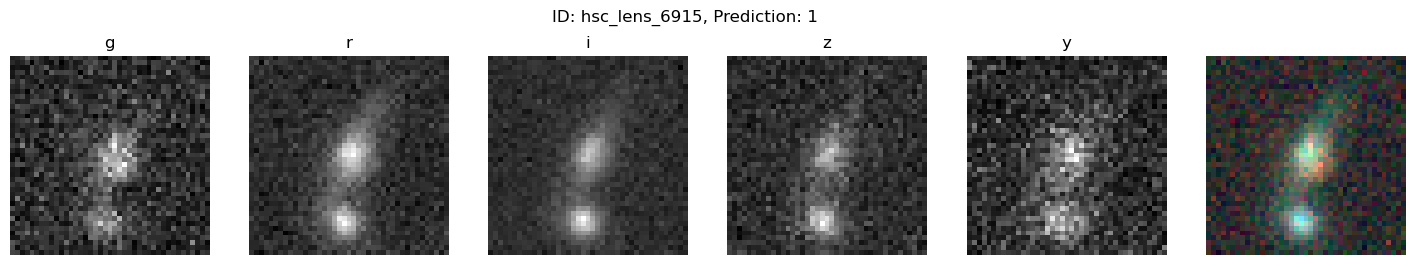

  0%|          | 1/100000 [00:00<10:28:15,  2.65it/s]

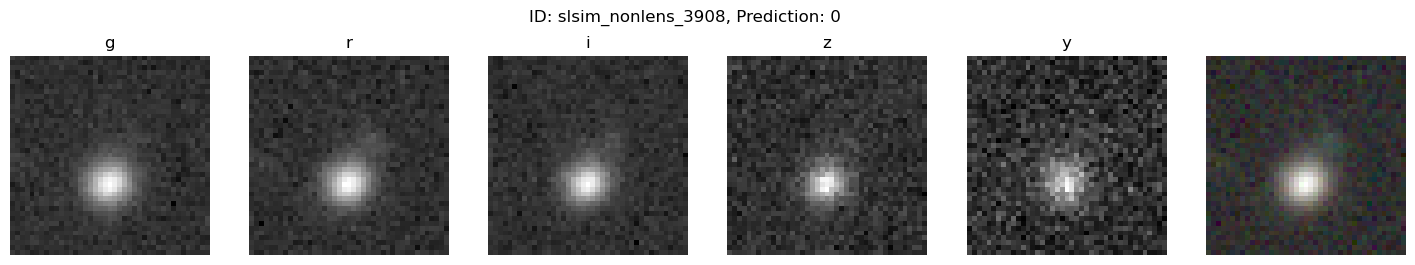

  0%|          | 2/100000 [00:00<9:35:56,  2.89it/s] 

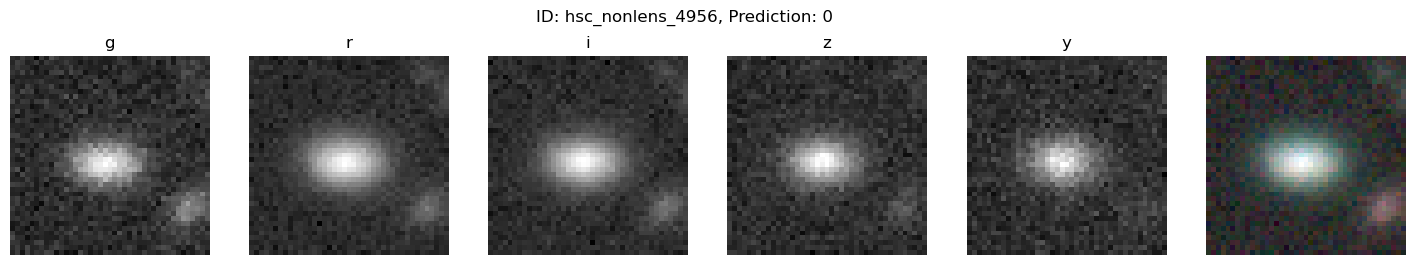

  0%|          | 3/100000 [00:01<9:42:30,  2.86it/s]

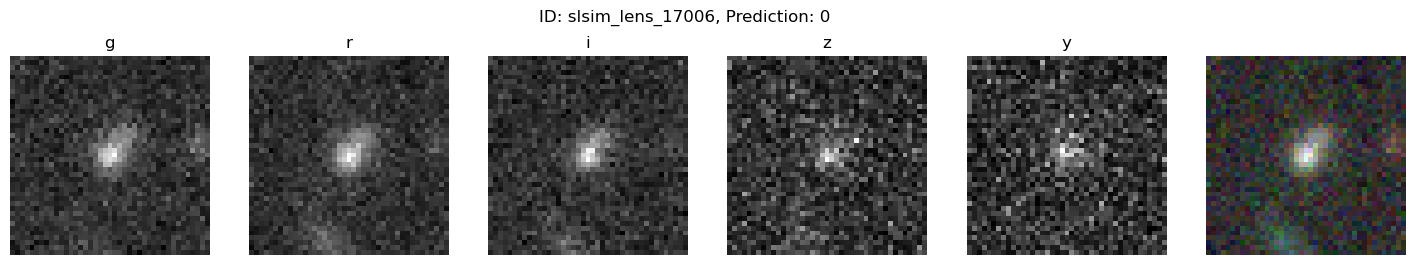

  0%|          | 4/100000 [00:01<13:31:07,  2.05it/s]

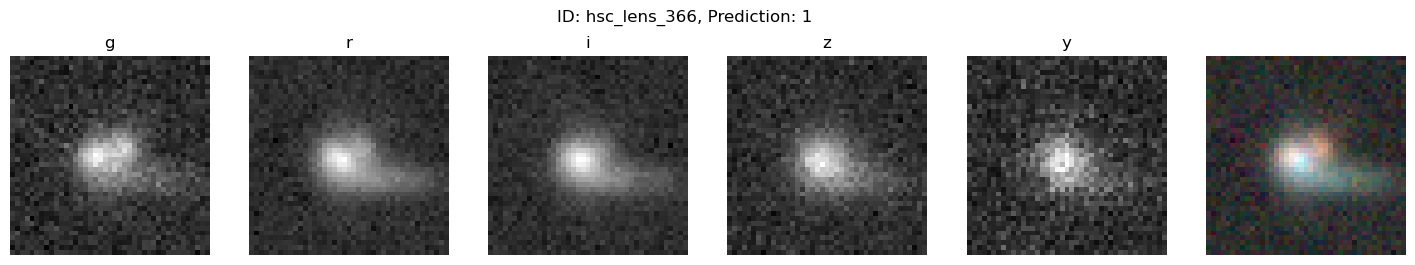

  0%|          | 5/100000 [00:02<11:38:46,  2.38it/s]

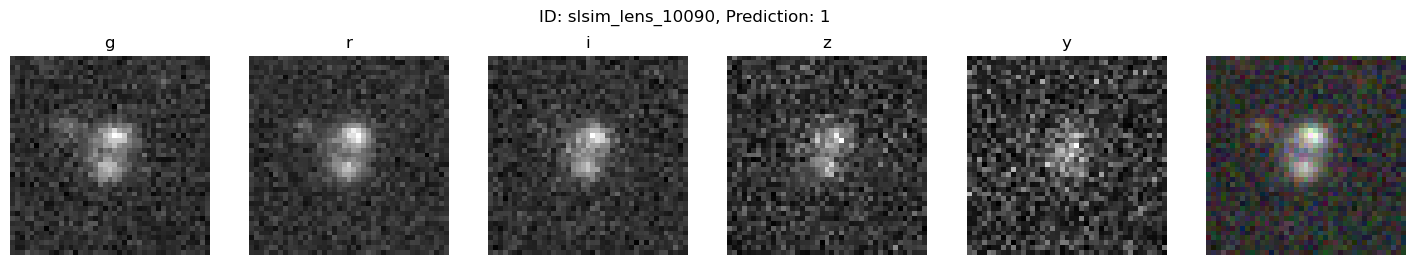

  0%|          | 6/100000 [00:02<11:42:45,  2.37it/s]

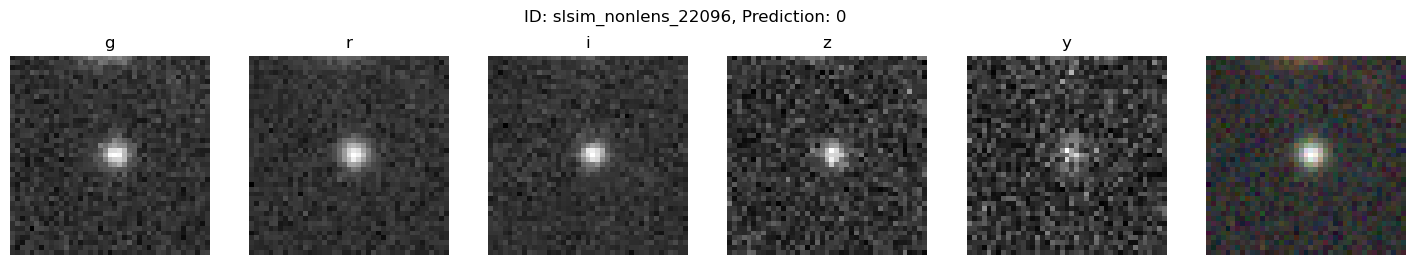

  0%|          | 7/100000 [00:02<10:48:52,  2.57it/s]

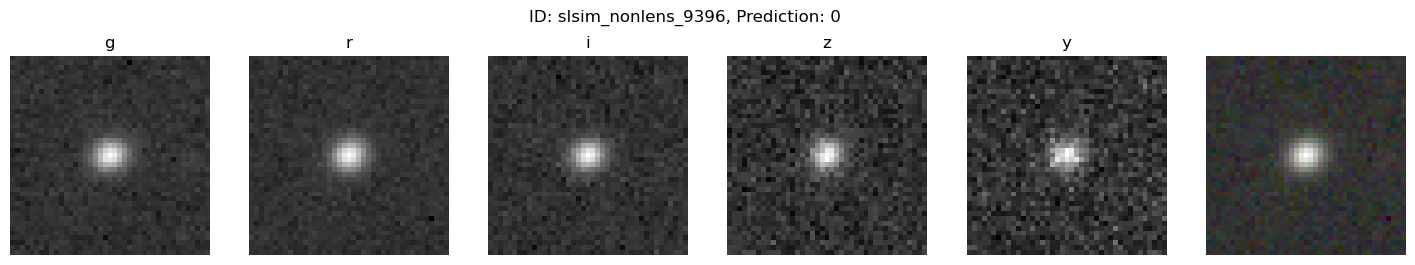

  0%|          | 8/100000 [00:03<10:09:39,  2.73it/s]

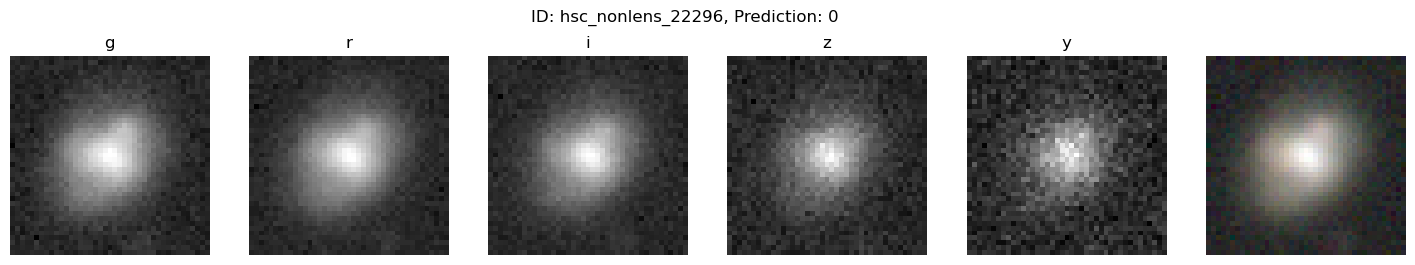

  0%|          | 9/100000 [00:03<9:45:36,  2.85it/s] 

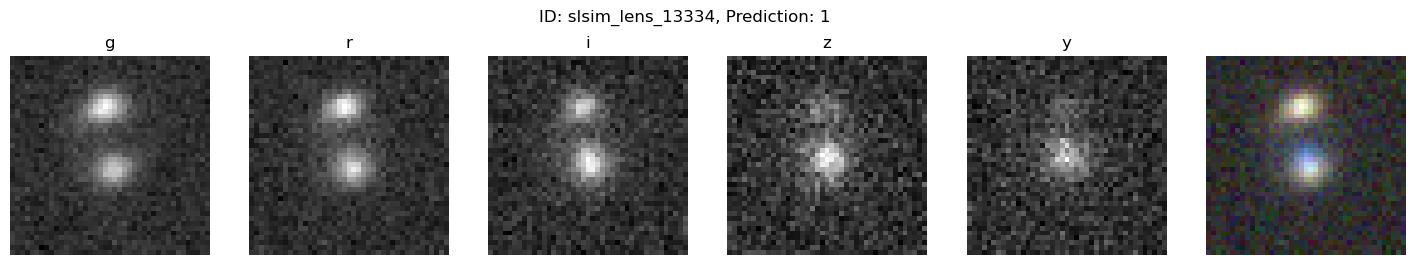

  0%|          | 10/100000 [00:03<9:30:00,  2.92it/s]

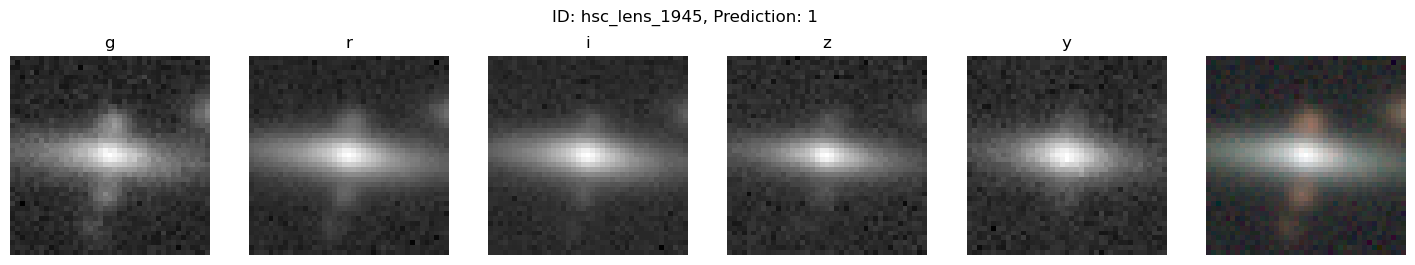

  0%|          | 11/100000 [00:04<9:20:08,  2.98it/s]

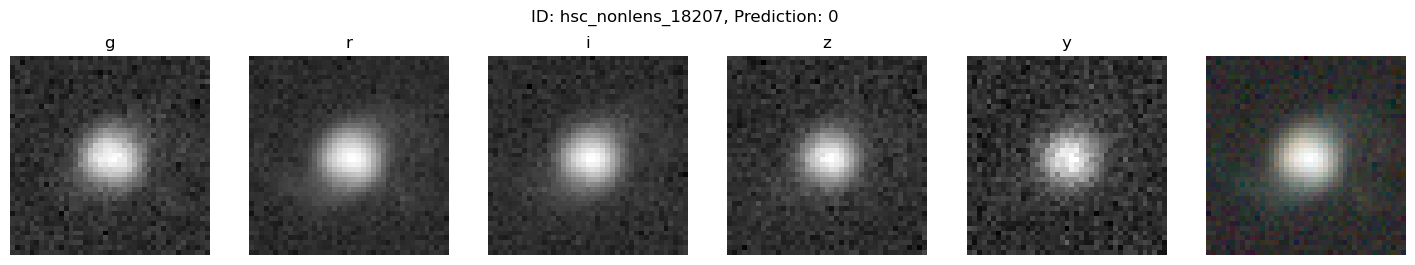

  0%|          | 12/100000 [00:04<9:14:13,  3.01it/s]

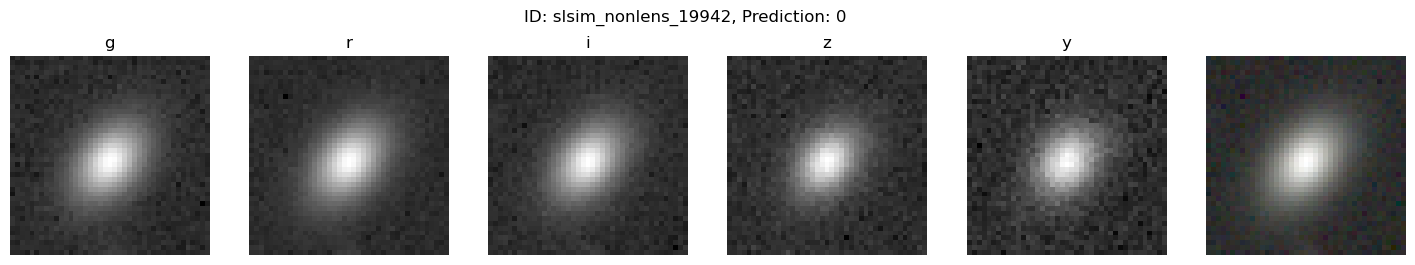

  0%|          | 13/100000 [00:04<8:57:38,  3.10it/s]

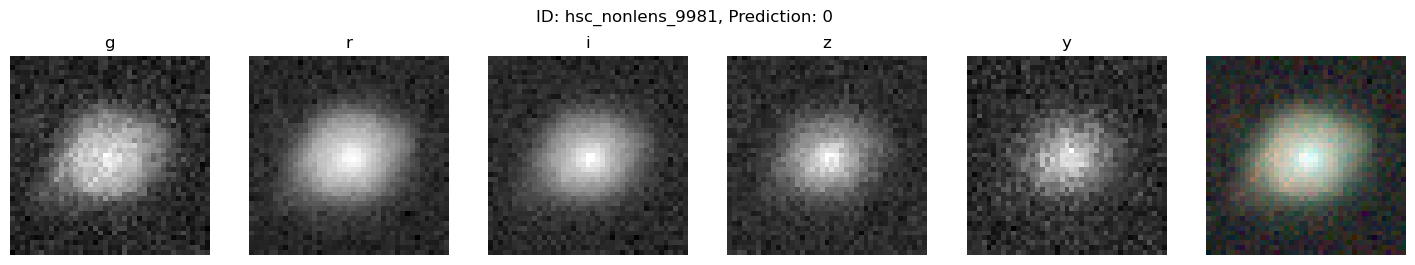

  0%|          | 14/100000 [00:04<8:43:40,  3.18it/s]

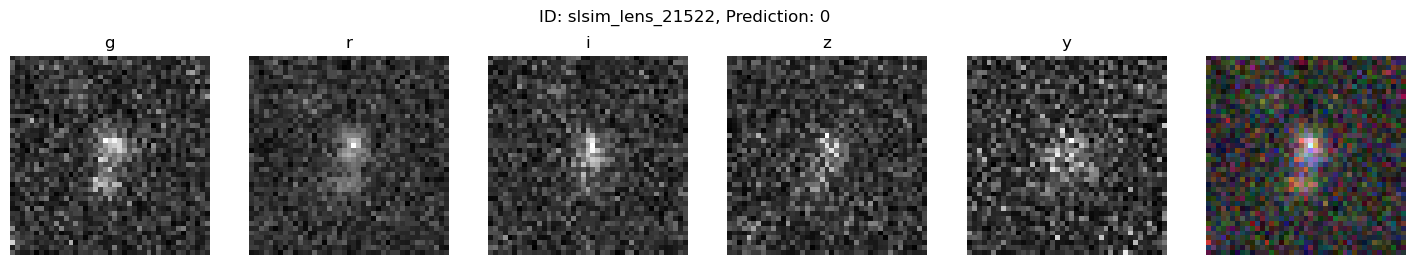

  0%|          | 15/100000 [00:05<8:38:18,  3.22it/s]

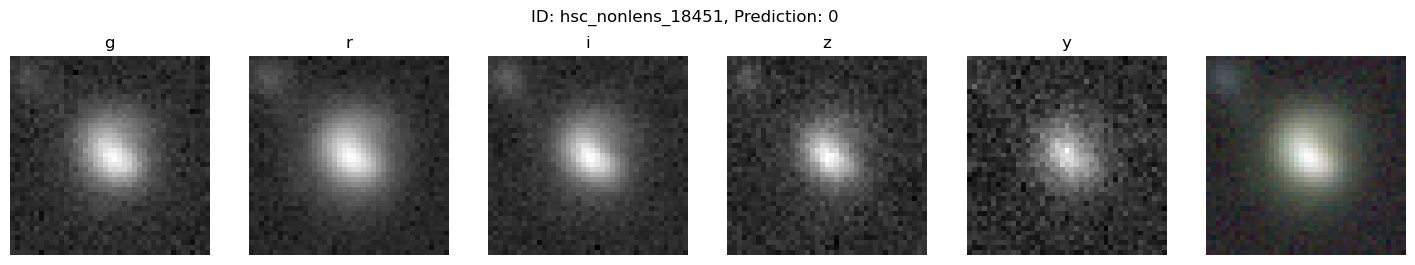

  0%|          | 16/100000 [00:05<8:32:30,  3.25it/s]

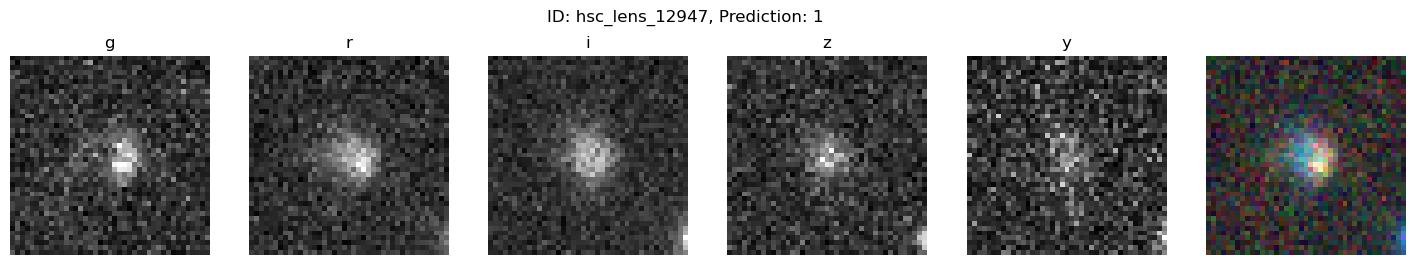

  0%|          | 17/100000 [00:05<8:37:28,  3.22it/s]

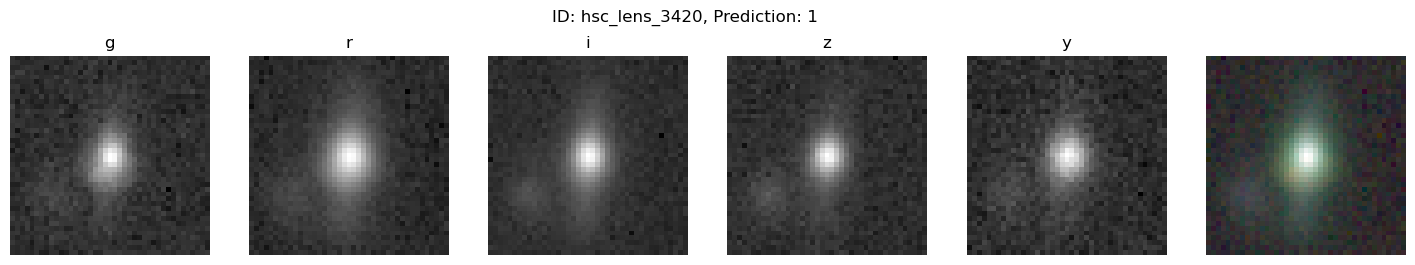

  0%|          | 18/100000 [00:06<8:29:01,  3.27it/s]

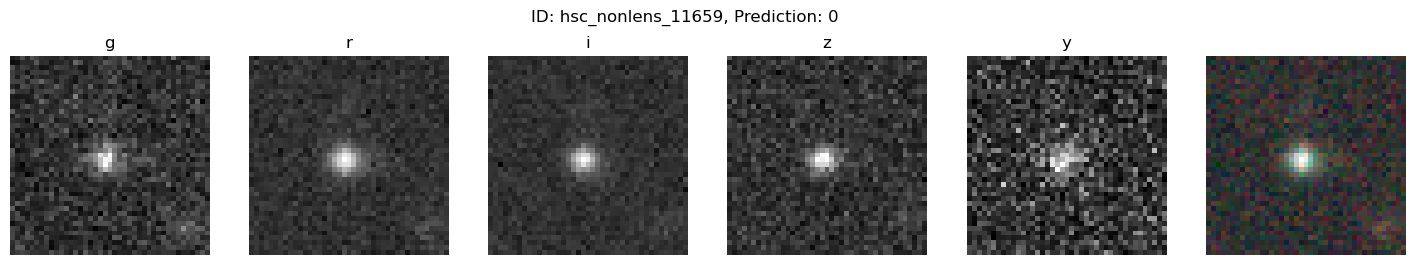

  0%|          | 19/100000 [00:06<8:25:18,  3.30it/s]

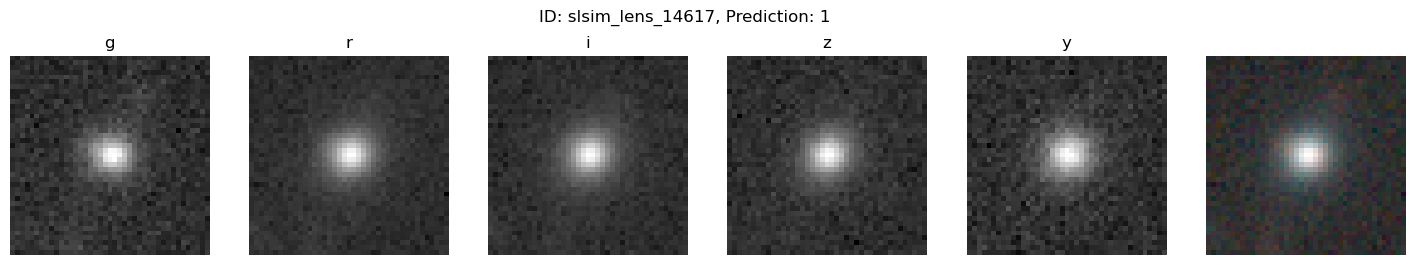

  0%|          | 20/100000 [00:06<8:22:42,  3.31it/s]

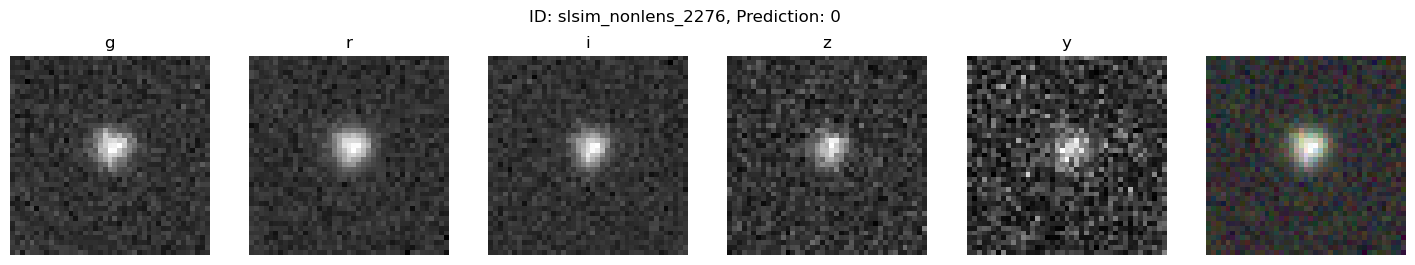

  0%|          | 21/100000 [00:07<8:21:27,  3.32it/s]

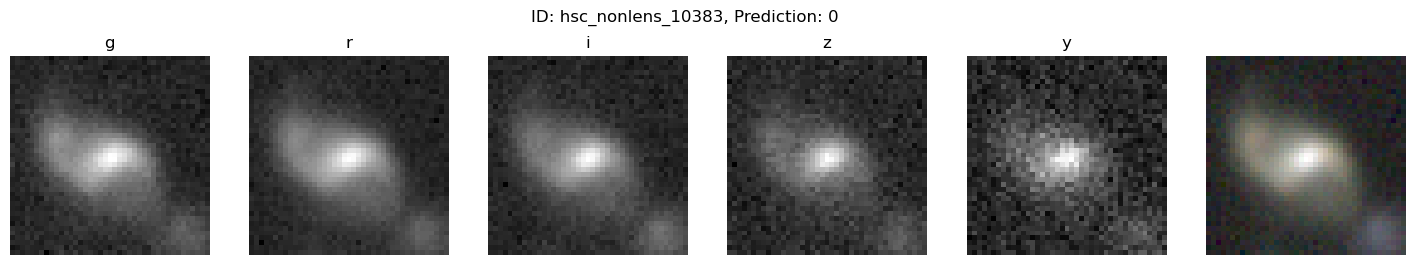

  0%|          | 22/100000 [00:07<8:22:22,  3.32it/s]

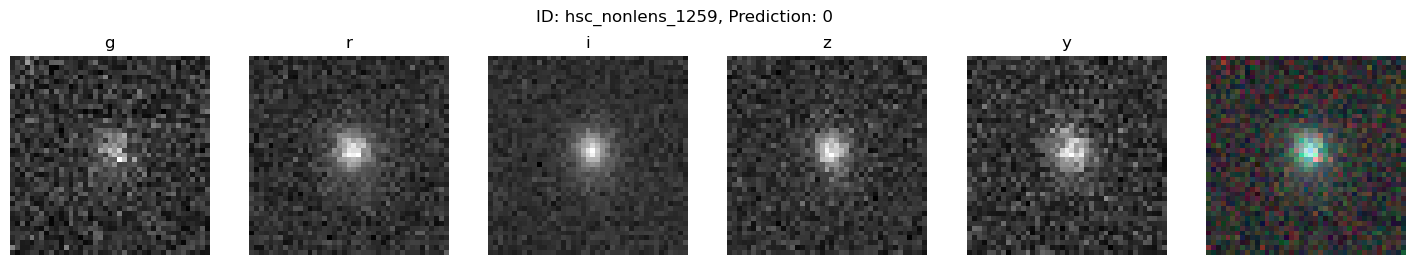

  0%|          | 23/100000 [00:07<8:23:03,  3.31it/s]

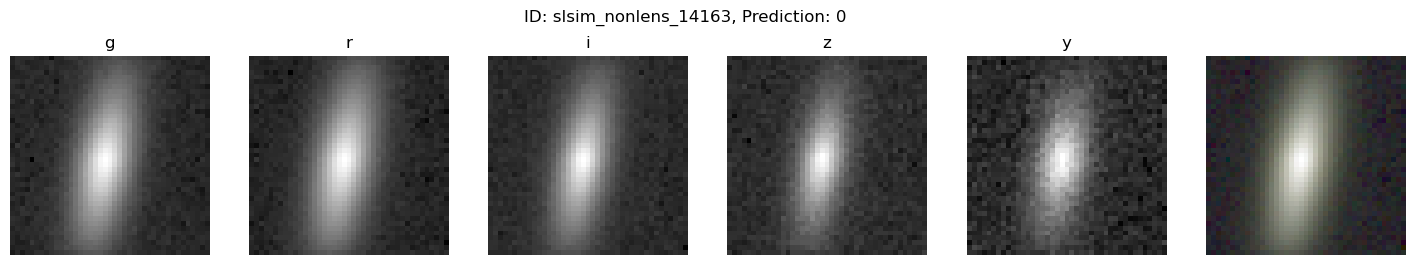

  0%|          | 24/100000 [00:08<8:28:50,  3.27it/s]

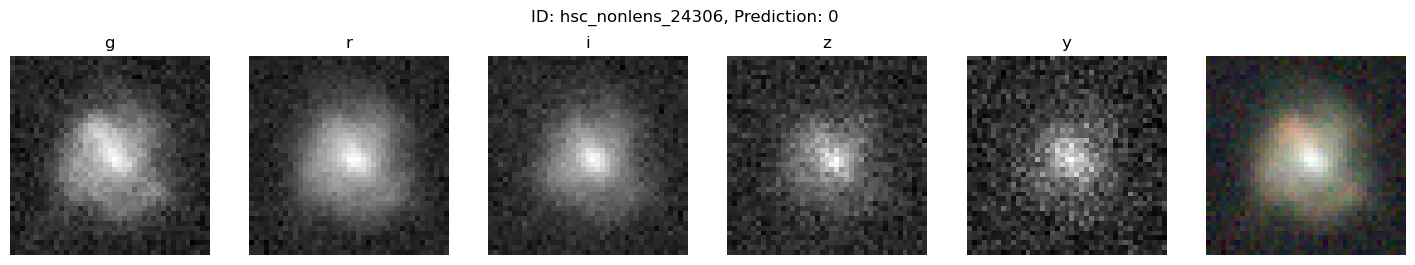

  0%|          | 25/100000 [00:08<8:31:37,  3.26it/s]

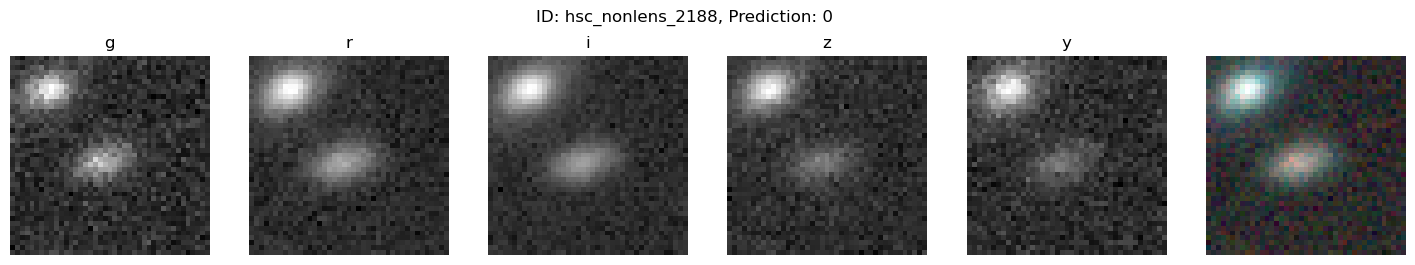

  0%|          | 25/100000 [00:09<10:08:26,  2.74it/s]


In [15]:
bands = ['g', 'r', 'i', 'z', 'y']

for i, unique_str in tqdm(enumerate(unique_ids), total=len(unique_ids)):
    images = []
    for band in bands:
        file_path = os.path.join(data_dir, f'{unique_str}_{band}.fits')
        id, image = get_image_data(file_path)
        images.append(process_image(image))
    image_stack = np.stack(images, axis=-1)

    # make prediction
    input_stack = np.expand_dims(image_stack, axis=0)  # add batch dimension for prediction
    preds = model.predict(input_stack, verbose=0)
    prediction = int(keras.ops.sigmoid(preds).numpy().flatten()[0] > 0.5)
    # print(f"ID: {id}, Prediction: {prediction}")

    # append to dataframe
    new_row = {'id': id, 'preds': prediction}
    df = pd.concat([df, pd.DataFrame([new_row], columns=df.columns)], ignore_index=True)

    # plot subset as sanity check
    if i % 1 == 0:
        f, ax = plt.subplots(1, 6, figsize=(18, 3))
        for j, band in enumerate(bands):
            ax[j].imshow(image_stack[:, :, j], cmap='gray')
            ax[j].set_title(band)
            ax[j].axis('off')
        ax[5].imshow(image_stack[:, :, :3])
        ax[5].axis('off')
        plt.suptitle(f"ID: {id}, Prediction: {prediction}")
        plt.savefig('sanity_check_figures/' + id + '.png')
        plt.show()

    if i == 25:
        break

In [16]:
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,hsc_lens_6915,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hsc_lens_6915,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hsc_lens_6915,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,slsim_nonlens_3908,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hsc_nonlens_4956,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,hsc_nonlens_10383,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,hsc_nonlens_1259,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,slsim_nonlens_14163,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475,hsc_nonlens_24306,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = df.fillna(-999)
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,hsc_lens_6915,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,hsc_lens_6915,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,hsc_lens_6915,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,slsim_nonlens_3908,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,hsc_nonlens_4956,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,hsc_nonlens_10383,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
473,hsc_nonlens_1259,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
474,slsim_nonlens_14163,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
475,hsc_nonlens_24306,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [18]:
df.to_csv('/data/bwedig/lsst-strong-lens-data-challenge/bryce_submission.csv', index=False)